# Run through an inclusionary example
Aksel Olsen
January 2015

Inclusionary housing means that the developmer, when providing market rate units, must also provide units at specified lower affordability levels, typically entailing a loss for the developer on that portion of the project. In San Francisco, this inclusionary rate is set at 12%, and although there are many footnotes to this (developers can 

1. choose to pay into a fund, in which case the fee goes up to 15%; 
1. develop a separate project off-site, but "close" to the principal project; or 
1. provide the units on-site in the principal project. 

Each jurisdiction does this differently, with different geographies, thresholds and variations, so we chose to set this up as a simple adjustment that could capture the main thrust--inclusionary housing is provided at lower levels of affordability, and, presumably, the overall housing geography / profitability would all other things equal be impacted by the changing fiscal map of development, with higher costs in jurisdictions with these ordinances. The latter requires an accounting of units, preferably in a data model at the scale of each unit, with unit-specific affordability attributes. (An easier way is to just assume that x percent of units built in years where jurisdiction x had an inclusionary ordinance on the books will be available to choosers at a set lower price in the household location choice model.) In either case, this has yet to be done. 

The implementation is pretty short and is reprinted in this notebook. The main version is stored in `bayarea_urbansim/variables.py`, in a decorated function named `parcel_average_price`. It replaces a function with the same name which is then needed in the feasibility calculation (`run_feasibility`) as invoked in `bayarea_urbansim/models.py`. 

The standard feasibility calculation uses `parcel_average_price` to know how much revenue would come from a(n in our case) residential project, picking the median from zone-level hedonic estimates. Our tweak is to *keep* this market rate accounting but *in addition* run a separate calculation of what the revenue would be for an inclusionary component of a project if units were sold not at market rates but at prices capped by some relationship to Area Median Income (San Francisco's target is for the 55% of AMI). The output of the function is then just the weighted average of the market-rate (i.e. hedonic-based) and inclusionary components.

The adjustment thus simply plugs in to the existing framework and works mainly through the `parcel_average_price` function, with some lookups added to make AMI levels visible. For county-level revenue levels, as a proxy we used HUD's county level 50% AMI levels and from these assumed 30% would be used on housing per month. 

In [1]:
import pandas as pd
import numpy as np

In [3]:
## plotting batteries
%pylab inline
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm, matplotlib.font_manager as fm
#pd.options.display.mpl_style = 'default'
rcParams['figure.figsize'] = 12, 7
sns.set(style="darkgrid")

Populating the interactive namespace from numpy and matplotlib


In [4]:
%load_ext autoreload
%autoreload 2

if 'sim' not in globals():
    import os; os.chdir('..')
import models
import urbansim.sim.simulation as sim
from urbansim.utils import misc

/home/aksel/env/lib/python2.7/site-packages/matplotlib/__init__.py:1256: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)
/home/aksel/env/lib/python2.7/site-packages/pkg_resources.py:991: UserWarning: /home/aksel/.python-eggs is writable by group/others and vulnerable to attack when used with get_resource_filename. Consider a more secure location (set with .set_extraction_path or the PYTHON_EGG_CACHE environment variable).
  warnings.warn(msg, UserWarning)


## Run the accessibility vars--needed for hedonic model later

In [5]:
sim.run(["neighborhood_vars"])

Running model 'neighborhood_vars'
Computing accessibility variables
Computing sum_residential_units
Filling column building_type_id with value 1.0 (17692 values)
Filling column residential_units with value 0 (17692 values)
Filling column year_built with value 1964.0 (251406 values)
Filling column non_residential_sqft with value 0 (34223 values)
Filling column building_type_id with value 1.0 (17692 values)
Filling column residential_units with value 0 (17692 values)
Filling column year_built with value 1964.0 (251406 values)
Filling column non_residential_sqft with value 0 (34223 values)
Filling column shape_area with value 594.846801758 (77 values)
Filling column zone_id with value 1178.0 (77 values)
Filling column shape_area with value 594.846801758 (77 values)
Filling column zone_id with value 1178.0 (77 values)
Removed 2208 rows because they contain missing values
Computing sum_residential_units_3500
Filling column building_type_id with value 1.0 (17692 values)
Filling column reside

## Hedonic Estimation
Supposedly we need to run the estimation to get building-level price vars

In [104]:
## write out results to file. We might use those later to push values to the buildings table. 
## Currently `residential_price` is all zeroes.

sim.run(["rsh_estimate"],data_out='rsh_estimate.h5')

Filling column shape_area with value 594.846801758 (77 values)
Filling column zone_id with value 1178.0 (77 values)
Filling column shape_area with value 594.846801758 (77 values)
Filling column zone_id with value 1178.0 (77 values)
Filling column shape_area with value 594.846801758 (77 values)
Filling column zone_id with value 1178.0 (77 values)
Running model 'rsh_estimate'
Filling column shape_area with value 594.846801758 (77 values)
Filling column zone_id with value 1178.0 (77 values)
Filling column shape_area with value 594.846801758 (77 values)
Filling column zone_id with value 1178.0 (77 values)
Filling column shape_area with value 594.846801758 (77 values)
Filling column zone_id with value 1178.0 (77 values)
Filling column shape_area with value 594.846801758 (77 values)
Filling column zone_id with value 1178.0 (77 values)
                              OLS Regression Results                              
Dep. Variable:     np.log(sale_price_flt)   R-squared:                      

In [105]:
sim.run(["rsh_simulate"],data_out='rsh_simulate.h5')

Filling column building_type_id with value 1.0 (17692 values)
Filling column residential_units with value 0 (17692 values)
Filling column year_built with value 1964.0 (251406 values)
Filling column non_residential_sqft with value 0 (34223 values)
Filling column building_type_id with value 1.0 (17692 values)
Filling column residential_units with value 0 (17692 values)
Filling column year_built with value 1964.0 (251406 values)
Filling column non_residential_sqft with value 0 (34223 values)
Filling column building_type_id with value 1.0 (17692 values)
Filling column residential_units with value 0 (17692 values)
Filling column year_built with value 1964.0 (251406 values)
Filling column non_residential_sqft with value 0 (34223 values)
Running model 'rsh_simulate'
Filling column building_type_id with value 1.0 (17692 values)
Filling column residential_units with value 0 (17692 values)
Filling column year_built with value 1964.0 (251406 values)
Filling column non_residential_sqft with value 

## STEP 1: Get main tables

In [107]:
#parcels = sim.get_table('parcels')#.to_frame()
buildings = sim.get_table('buildings')#.to_frame()

Filling column building_type_id with value 1.0 (17692 values)
Filling column residential_units with value 0 (17692 values)
Filling column year_built with value 1964.0 (251406 values)
Filling column non_residential_sqft with value 0 (34223 values)


In [53]:
parcels = sim.get_table('parcels')#.to_frame()
buildings = sim.get_table('buildings')#.to_frame()

0.05


In [84]:
from urbansim.developer import sqftproforma
settings = sim.settings
USE = "residential"
QUANTILE=.5

## STEP 2: Calculate generic revenue for inclusionary units affordable to 50% AMI
Below follows a simple calculation of revenue assuming units are built for 2-person households earning 50% of AMI pay 30% of their income on housing.

In [94]:
## for this lookup to work, the table needs to be registered in bayarea_urbansim/datasources.py

bmr_prices = sim.get_table('HUD_below_market_rate_rent')
bmr_prices.to_frame().head()

,Unnamed: 0,1-Person,2-Person,3-Person,4-Person,5-Person,6-Person,7-Person,8-Person
fips,,,,,,,,,
1,0,805.00,920.0,1035.00,1150.00,1242.50,1335.00,1426.25,1518.75
13,1,805.00,920.0,1035.00,1150.00,1242.50,1335.00,1426.25,1518.75
85,2,892.50,1020.0,1147.50,1273.75,1376.25,1478.75,1580.00,1682.50
55,3,721.25,825.0,927.50,1030.00,1112.50,1195.00,1277.50,1360.00
81,4,968.75,1107.5,1246.25,1383.75,1495.00,1606.25,1716.25,1827.50


## For now, county-level HUD 2-person households are used as a placeholder rent target assumption

In [67]:
rev_per_mo_per_unit = bmr_prices['2-Person'].to_dict()
rev_per_mo_per_unit

{1: 920.0,
 13: 920.0,
 41: 1107.5,
 55: 825.0,
 75: 1107.5,
 81: 1107.5,
 85: 1020.0,
 95: 767.5,
 97: 770.0}

## We need to translate the revenue per unit to a per square footage measure, in yearly terms
For this we need some translator constants. We grab from the model settings:

In [87]:
SQFT_PER_UNIT = settings['residential_developer']['min_unit_size']
CAP_RATE = sqftproforma.SqFtProForma().config.cap_rate
print SQFT_PER_UNIT
print CAP_RATE

1000
0.05


## Get county-level expected sales *yearly revenue per sq ft* for the inclusionary square feet. 

Watch out for possible built-in conversions btw rent/own valuations--here we just assume sales.

TODO: we should use the existing rent / own conversion interface instead.

This yields values around $265 per square foot, give or take, maybe about a third to a half
of the market rate estimates currently, depending on the place. This seems low, but not crazy.

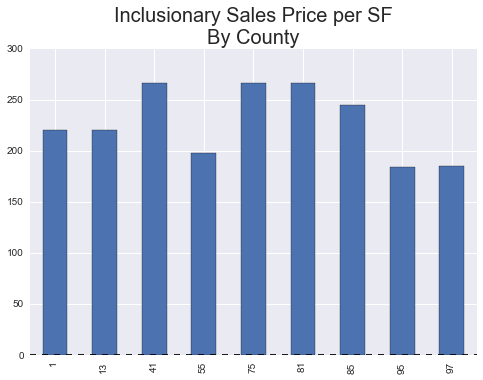

In [95]:
rev_per_sqft = pd.Series(rev_per_mo_per_unit).\
    apply(lambda x: x/ SQFT_PER_UNIT*12 / CAP_RATE).to_dict()

## plot it    
pd.Series(rev_per_sqft).plot(kind='bar');title('Inclusionary Sales Price per SF\nBy County',size=20)

## STEP 3: Push these county-level BMR revenue per sq ft estimates (generic) to the parcel level, going through county-to-city-to-parcel-level relationships.


Note that since the HUD numbers came at the county level, all parcels in the same county will
have the same estimated revenue per square foot for any inclusionary unit.

TODO: a bunch of these temporary variables we probably don't need to store in the parcel table--we just need them temporarily, so they could just be series.


In [90]:
## fetch a translator of arbitrary county ids in urbansim to FIPS codes, since many official data sources use FIPS codes
county_id_to_fips=sim.get_injectable('county_id_to_fips')
county_id_to_fips

{1: 1, 7: 13, 21: 41, 28: 55, 38: 75, 41: 81, 43: 85, 48: 95, 49: 97}

In [92]:
## translate county id to FIPS, then map this to FIPS-level revenue per square foot calculated earlier. 

parcels['incl_price_per_sf'] = parcels.county_id.fillna(-1).\
astype(np.int64).map(county_id_to_fips).map(rev_per_sqft)

parcels['incl_price_per_sf'].head()

parcel_id
1            265.8
2            265.8
3            265.8
4            265.8
5            265.8
Name: incl_price_per_sf, dtype: float64

## STEP 4: Do the actual parcel-level weighting of revenue

First we take building-level `residential_price` data for residential buildings, take the median in the zone, and then push this number back to the parcel level. 

TODO: res hedonic model needs to be run and simulated first to get a buildings table output; otherwise zeroes will result. This does not currently happen, so `residential_price` is 0 across the board. This needs to be fixed before any practical use and evaluation.

In [108]:
buildings.residential_price[buildings.general_type == "Residential"].describe()

count    1796149
mean           0
std            0
min            0
25%            0
50%            0
75%            0
max            0
dtype: float64

In [93]:
## so in theory this should return meaningful values, but `residential_price` is full of zeroes. 
## Fletcher or Mike probably have a more 'live' version of the buildings table. 
## Or we could just merge hedonic estimates on manually. Anyway, we continue the exercise just to get the bindings set up.

market_rate = misc.reindex(buildings.residential_price[buildings.general_type == "Residential"].\
                    groupby(buildings.zone_id).quantile(QUANTILE),
                    sim.get_table('parcels').zone_id) 

Filling column shape_area with value 594.846801758 (77 values)
Filling column zone_id with value 1178.0 (77 values)


Then we grab jurisdiction-level data on presence of inclusionary programs, for which purpose we have a lookup table / injectable called `inclusionary_rates` with a row for each `jurisdiction_id`. What are rates in these jurisdictions (at the city level)?
Note that these are placeholder values--we don't have a compilation of such rates, but ABAG is going to be collecting them over the summer. For now, we just assumed 12 percent for jurisdictions we know have SOME inclusionary program. This needs to be checked.

In [97]:
## load inclusionary rates, indexed on the 100+ jurisdiction ids. Whatever these jurisdictions actually are used to be stored on Paris.
inclusionary_rates = sim.get_injectable('inclusionary_rates')
s_inclusionary_rates = pd.Series(inclusionary_rates)

s_inclusionary_rates.tail()

97     0.12
98     0.12
99     0.00
100    0.00
101    0.12
dtype: float64

Then, flag cities w inclusionary rates larger than 0, and send this values to parcels.

In [99]:
city_has_inclusionary = s_inclusionary_rates[s_inclusionary_rates>0].to_dict()
parcels['incl_rate'] = parcels.city_id.fillna(-1).astype(np.int64).map(city_has_inclusionary).fillna(0)

# the first 153,000 parcels are San Francisco ones, so they all have 12% incl rates
parcels['incl_rate'].head()  

parcel_id
1            0.12
2            0.12
3            0.12
4            0.12
5            0.12
Name: incl_rate, dtype: float64

## Result: A weighted avg of the market rate and inclusionary hsg constrained revenue assumption
Assuming a small-ish inclusionary rate, the number should be close to, but lower than, the market rate sales revenue per sf. This should be safe to calculate even for jurisdictions with no inclusionary policy--jurisdictions with zero inclusionary will just have a zero in the first term, and 100% of the market rate in the second.

In [80]:
## eg. .12           * 332.25                       + (1-.12)                 * 800
parcels['incl_rate'] * parcels['incl_price_per_sf'] + (1-parcels['incl_rate'])* market_rate

parcel_id
1            31.896
2            31.896
3            31.896
4            31.896
5            31.896
6            31.896
7            31.896
8            31.896
9            31.896
10           31.896
11           31.896
12           31.896
13           31.896
14           31.896
15           31.896
...
2079320     NaN
2079321     NaN
2079322     NaN
2079323     NaN
2079324     NaN
2079325     NaN
2079326     NaN
2079327     NaN
2079328     NaN
2079329     NaN
2079330     NaN
2079331     NaN
2079332     NaN
2079333     NaN
2079334     NaN
Length: 2020794, dtype: float64

## Further work needed:
* What this does is mainly change the cost structure of feasibility, meaning they are slightly less profitable in jurisdictions with inclsionary requirements. Note that there is no treatment of the incidence of this 'tax'--perhaps it is passed on to the consumer as much as being borne by the developer--if so, cost shifters should adjust overall prices levels for jurisdictions with such policies on the books. It goes without saying that the market rate prices need to NOT be all zeroes as they currently exist in my version of the buildings table. It may just be a matter of writing the output from the hedonic estimation to the table in the main datastore.
* Secondly, units actually produced in these jurisdictions need to be flagged and accounted for so they are visible in the `household location choice` model. A decision needs to be made as to the nature of this flag. It may be desirable to move to a unit-level representation--each unit becomes a row in a table and is maintained during the simulation, with appropriate attributes describing size, deed-restricted affordability, tenure, etc. Currently, some of this lives in the `buildings` table. If such a migration of unit of analysis were to happen, the hedonic model would need to leave deed restricted units alone.
* Third, there is no real distinction between owner and renter units. That may be desirable, even if Costa-Hawkins means less rental affordable units produced.